# Fatal Police Shootings

*author: Celine Ng*

# 1. Import Libraries &  Data Retrieval

In [90]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [92]:
db = pd.read_csv("database.csv")

In [93]:
db

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,2382,James Leroy Marker,2017-02-26,shot,gun,66.0,M,W,Floral City,FL,False,other,Car,False
2138,2378,Joey J. Bridges,2017-02-27,shot,gun,27.0,M,W,Shelby,NC,True,attack,Foot,False
2139,2391,Shawn M. Igers,2017-02-27,shot,gun,40.0,M,W,Corning,WI,False,attack,Not fleeing,False
2140,2393,Earl Riley,2017-02-28,shot,gun,25.0,M,B,Houston,TX,False,attack,Not fleeing,False


# 2. Quick Exploration & Data Cleaning

## 2.1 Missing values

**Summary:
After locating the missing values, quick visualization and exploration were 
applied to understand the which are the best treatments. There are too 
many missing values and rows containing missing values, therefore 
imputation method was used in most cases. For columns "name" and "race", due
to its irrelevance and complication to impute data, missing data are not 
treated.**

1. Is there any empty values?

In [94]:
db.isnull().any()

id                         False
name                        True
date                       False
manner_of_death            False
armed                       True
age                         True
gender                      True
race                        True
city                       False
state                      False
signs_of_mental_illness    False
threat_level               False
flee                        True
body_camera                False
dtype: bool

2. How many empty values are there?

In [95]:
db.isnull().sum().sum()

208

In [96]:
empty_values = db.isnull().sum()
empty_values

id                           0
name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'race'),
  Text(1, 0, 'age'),
  Text(2, 0, 'flee'),
  Text(3, 0, 'name'),
  Text(4, 0, 'armed'),
  Text(5, 0, 'gender'),
  Text(6, 0, 'id'),
  Text(7, 0, 'date'),
  Text(8, 0, 'manner_of_death'),
  Text(9, 0, 'city'),
  Text(10, 0, 'state'),
  Text(11, 0, 'signs_of_mental_illness'),
  Text(12, 0, 'threat_level'),
  Text(13, 0, 'body_camera')])

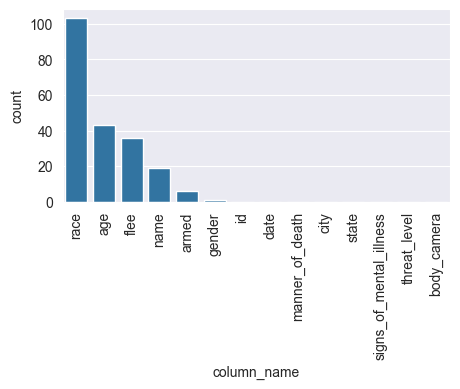

In [97]:
empty_values_df = empty_values.reset_index()
empty_values_df.columns = ["column_name", "count"]
empty_values_df_ordered = empty_values_df.sort_values(
    "count", ascending=False)

plt.figure(figsize=(5, 2.5))
sns.barplot(data=empty_values_df_ordered, 
            x=empty_values_df_ordered["column_name"], 
            y=empty_values_df_ordered["count"])
plt.xticks(rotation=90)          

3. How many rows with empty values?

In [98]:
rows_with_emtpy = db[db.isnull().any(axis=1)]
rows_with_emtpy

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
59,110,William Campbell,2015-01-25,shot,gun,59.0,M,NaN,Winslow,NJ,False,attack,Not fleeing,False
124,584,Alejandro Salazar,2015-02-20,shot,gun,NaN,M,H,Houston,TX,False,attack,Car,False
241,244,John Marcell Allen,2015-03-30,shot,gun,54.0,M,NaN,Boulder City,NV,False,attack,Not fleeing,False
266,534,Mark Smith,2015-04-09,shot and Tasered,vehicle,54.0,M,NaN,Kellyville,OK,False,attack,Other,False
340,433,Joseph Roy,2015-05-07,shot,knife,72.0,M,NaN,Lawrenceville,GA,True,other,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,2345,Mauro Garnica,2017-02-15,shot,unknown weapon,55.0,M,NaN,Newman,CA,False,attack,Not fleeing,False
2125,2373,Kenneth Robertson,2017-02-23,shot,gun,54.0,M,NaN,Fairfax,OK,False,attack,Not fleeing,False
2132,2383,Lorenzo Antoine Cruz,2017-02-25,shot,toy weapon,23.0,M,NaN,Rocklin,CA,False,attack,Foot,False
2133,2384,NaN,2017-02-25,shot,gun,NaN,NaN,NaN,Lumpkin,GA,False,attack,Car,False


In [99]:
number_rows = rows_with_emtpy.shape[0]
number_rows

156

4. What is the percentage of rows containing missing values out of all rows?

In [100]:
db_rows = db.shape[0]
number_rows/db_rows

0.07282913165266107

7% is too much data to delete. Can not simply delete rows containing empty 
values.

5. What is the percentage of missing values in each column?

In [101]:
empty_values_df["%"] = empty_values_df["count"]*100/db_rows
empty_values_df

,column_name,count,%
0,id,0,0.000000
1,name,19,0.887021
2,date,0,0.000000
3,manner_of_death,0,0.000000
4,armed,6,0.280112
5,age,43,2.007470
6,gender,1,0.046685
7,race,103,4.808590
8,city,0,0.000000
9,state,0,0.000000


No column has enough missing values to be removing the whole column.

### Imputation (median, mode)
Instead of deleting data, we will leave name and race as it is and impute 
data for the rest: age, flee, armed, gender.
Visualizing the distribution will help pick which imputation method affects 
the least our data analysis. 

6. How may unique values for *armed*, *age*, *gender*, *flee* ? 

In [102]:
db["armed"].nunique()

64

In [103]:
db["age"].nunique()

71

In [104]:
db["gender"].nunique()

2

In [105]:
db["flee"].nunique()

4

7. How many of each?

In [106]:
db.armed.value_counts()

armed
gun                                 1173
knife                                319
unarmed                              155
vehicle                              136
undetermined                         101
                                    ... 
bean-bag gun                           1
baseball bat and fireplace poker       1
straight edge razor                    1
hand torch                             1
pole and knife                         1
Name: count, Length: 64, dtype: int64

In [107]:
db.age.value_counts()

age
25.0    85
31.0    82
36.0    79
29.0    75
26.0    65
        ..
80.0     1
14.0     1
82.0     1
13.0     1
73.0     1
Name: count, Length: 71, dtype: int64

In [108]:
db.gender.value_counts()

gender
M    2052
F      89
Name: count, dtype: int64

In [109]:
db.flee.value_counts()

flee
Not fleeing    1453
Car             318
Foot            254
Other            81
Name: count, dtype: int64

Visualizing it.

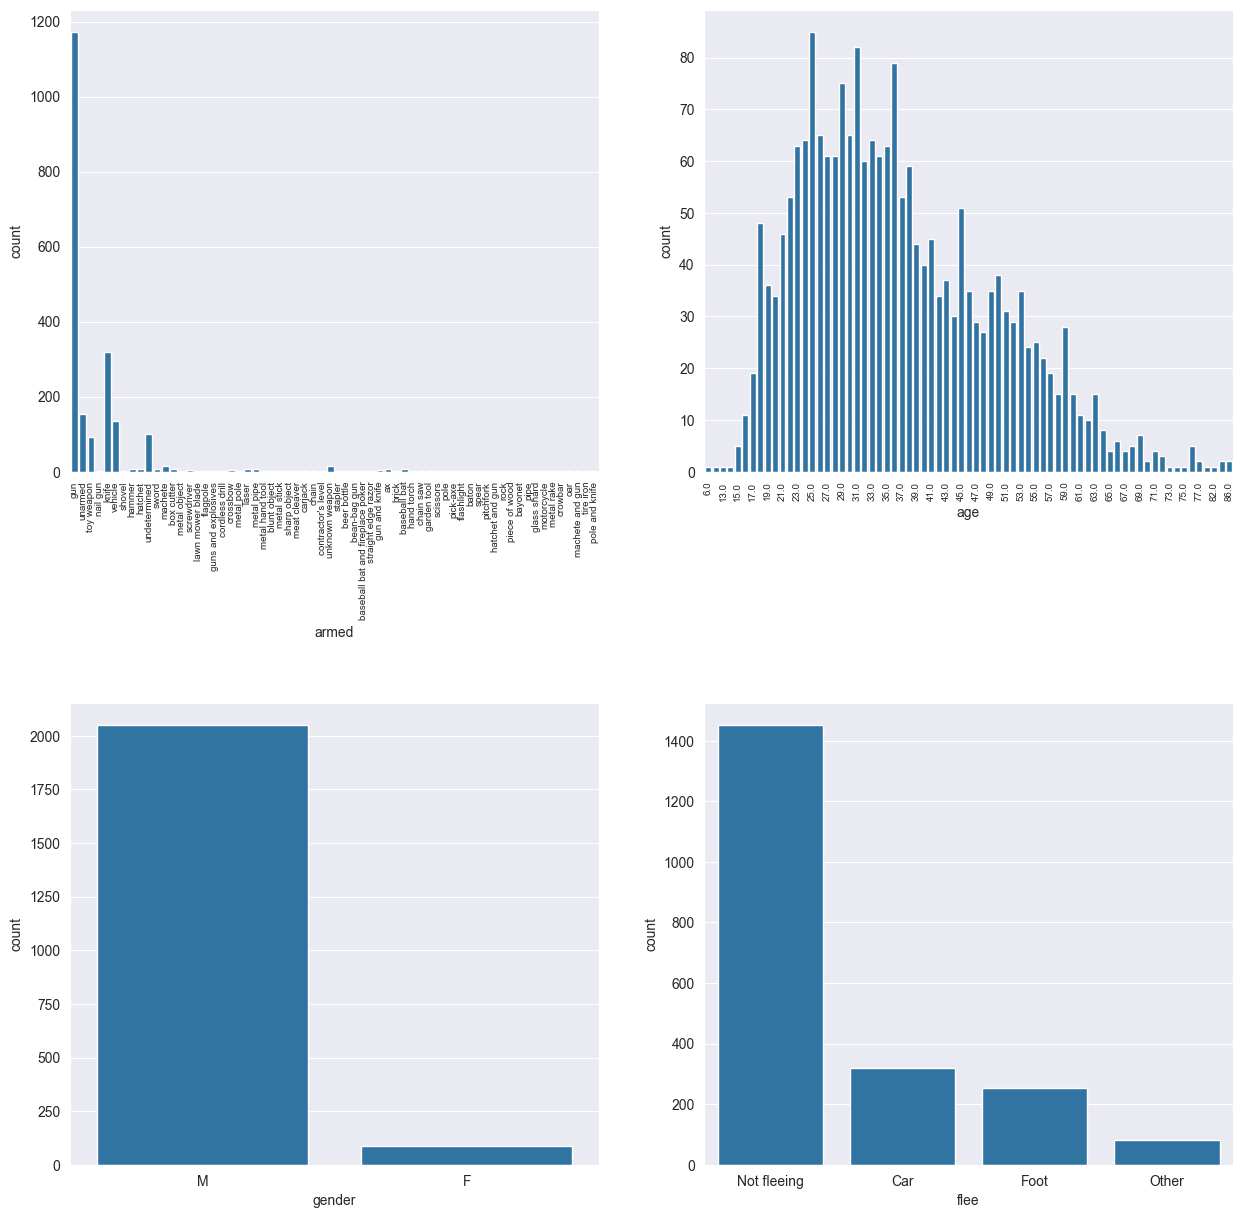

In [110]:
fig = plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=db, x=db["armed"])
plt.xticks(rotation=90, fontsize=7)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=db, x=db["age"])
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune="both", 
                                        nbins=len(db["age"].unique())//2))
plt.xticks(rotation=90, fontsize=7)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=db, x=db["gender"])

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=db, x=db["flee"])

plt.subplots_adjust(hspace=0.5)

**Imputation** 

In [111]:
db_replaced = db.copy()

db_replaced["armed"] = db["armed"].fillna(db["armed"].mode()[0])
db_replaced["gender"] = db["gender"].fillna(db["gender"].mode()[0])
db_replaced["flee"] = db["flee"].fillna(db["flee"].mode()[0])
db_replaced["age"] = db["age"].fillna(db["age"].median())

Visualizing for better comparison to see influence of replaced values.

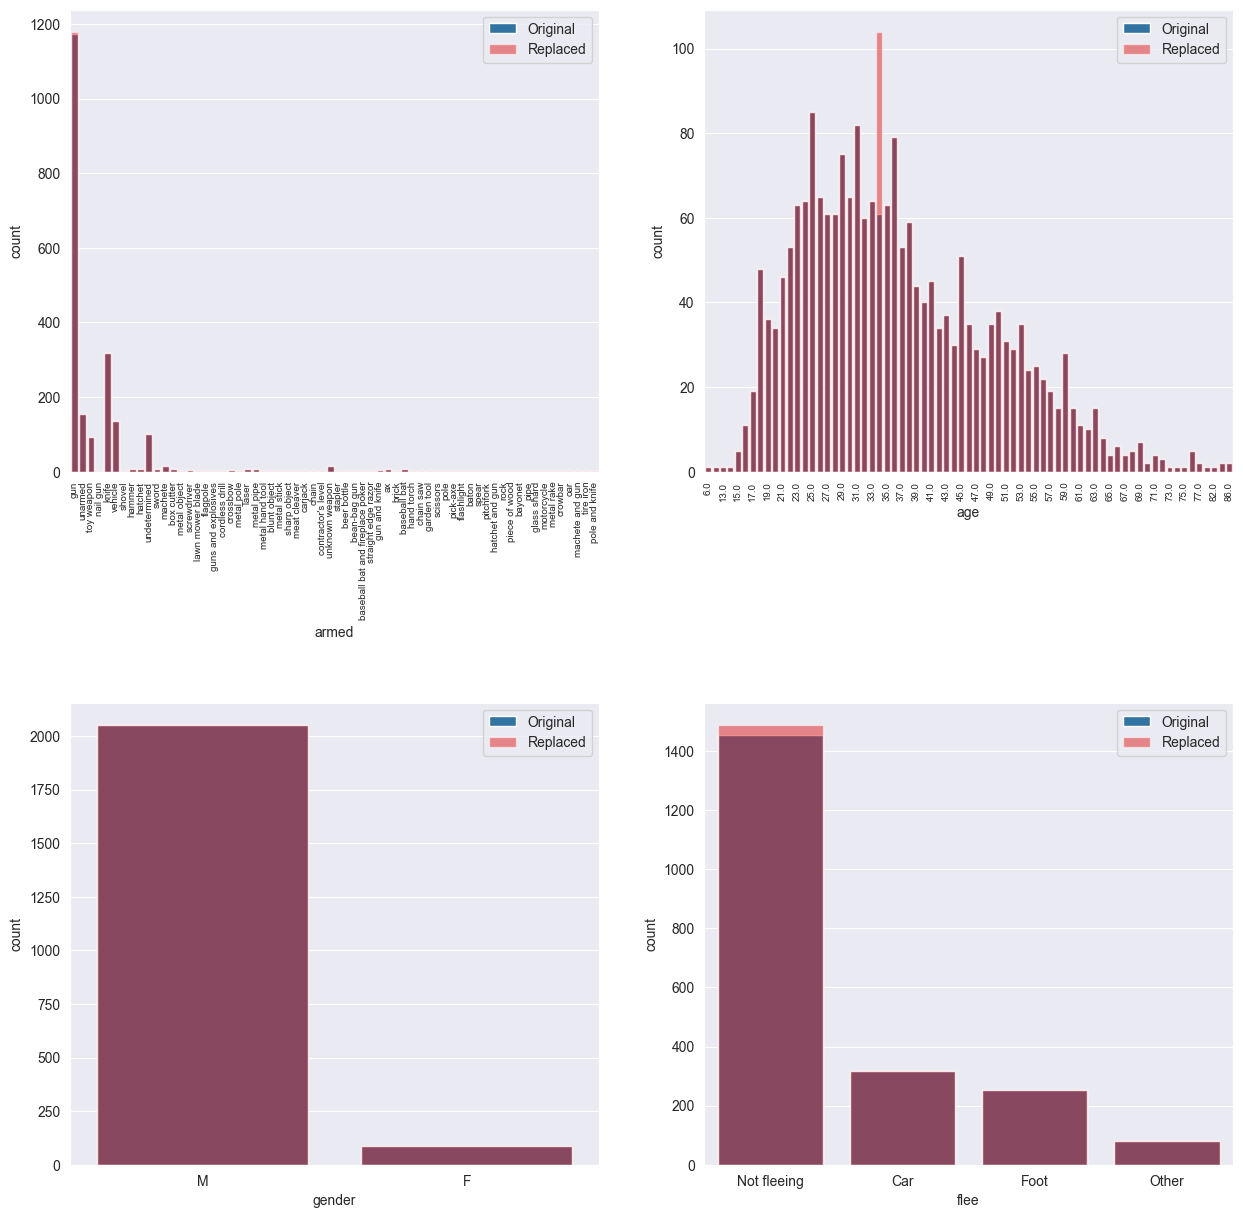

In [118]:
fig = plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=db, x=db["armed"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["armed"], color="red", 
              label="Replaced", alpha=0.5)
plt.xticks(rotation=90, fontsize=7)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=db, x=db["age"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["age"], color="red", 
              label="Replaced", alpha=0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune="both", 
                                        nbins=len(db["age"].unique())//2))
plt.xticks(rotation=90, fontsize=7)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=db, x=db["gender"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["gender"], color="red", 
              label="Replaced", alpha=0.5)

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=db, x=db["flee"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["flee"], color="red", 
              label= "Replaced", alpha=0.5)

plt.subplots_adjust(hspace=0.5)

8. Did the new values change the data statistics for *age* ?

In [121]:
db["age"].describe()

count    2099.000000
mean       36.484516
std        12.874000
min         6.000000
25%        26.000000
50%        34.000000
75%        45.000000
max        86.000000
Name: age, dtype: float64

In [122]:
db_replaced["age"].describe()

count    2142.000000
mean       36.434641
std        12.748828
min         6.000000
25%        27.000000
50%        34.000000
75%        45.000000
max        86.000000
Name: age, dtype: float64

## 2.2 Duplicates

**Summary: No duplicates in dataset.**

9. Is there any duplicated rows? 

In [131]:
db_replaced.duplicated().any()

False

10. Is there any same case/Id?

In [132]:
db_replaced.id.duplicated().any()

False

## 2.3 Inadequate Datatypes

**Summary: Columns *date* and *age* datatypes are changed to datetime64 and 
int64.**

11. What are the data types of each column? 

In [133]:
db_replaced.dtypes

id                           int64
name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
dtype: object

Age and date datatypes are inadequate.

In [139]:
db_replaced.age = db_replaced.age.astype("int64")

In [141]:
db_replaced["date"] = pd.to_datetime(db_replaced["date"], format="%Y-%m-%d")

In [143]:
db_replaced.dtypes

id                                  int64
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                                 int64
gender                             object
race                               object
city                               object
state                              object
signs_of_mental_illness              bool
threat_level                       object
flee                               object
body_camera                          bool
dtype: object

## 2.4 Others/Outliers/Data visualization

- plot the distribution of the rest
- max and min for age
- outliers with IQR?

In [115]:
db.shape

(2142, 14)

In [116]:
len(db.name.unique())

2119